#**Regularization: 규제**
과대/과소적합을 해결하는 대표적인 방법 중 하나는 **'가중치 규제'**이다.

가중치 규제란 말 그대로 가중치의 값이 너무 커지지 않게 제한하는 기법이다.

SingleLayer 클래스에 L1, L2 규제를 적용해보자.

In [ ]:
# import dependencies

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
c_data = cancer.data
c_target = cancer.target
train_data_all, test_data, train_target_all, test_target = train_test_split(c_data, c_target, stratify=c_target, test_size=0.2, random_state=42)
train_data, val_data, train_target, val_target = train_test_split(train_data_all, train_target_all, stratify=train_target_all, test_size=0.2, random_state=42)
train_mean = np.mean(train_data, axis=0)
train_std = np.std(train_data, axis=0)
train_data_scaled = (train_data - train_mean) / train_std
val_data_scaled = (val_data - train_mean) / train_std

#**L1 Regularization: L1 규제**

L1 규제는 손실함수에 가중치의 절댓값인 L1 norm을 추가해준다.
###$$
  L1\,norm = ||w||_1 = \displaystyle\sum_{i=1}^{n}|w_i|
$$
(※ 여기서 소문자 알파벳 w는 벡터를 의미한다.)

L1 규제는 간단히 '가중치의 절댓값을 손실함수에 더한 것'으로 이해해도 무방하다.

다음은 로지스틱 손실함수에 L1 규제를 적용해보자

###$$
  L = -(ylog(a) + (1 - y)log(1 - a)) + α\displaystyle\sum_{i=1}^{n}|w_i|
$$

α는 L1 규제의 양을 조절하는 하이퍼파라미터이다.   
 - α값이 크면 전체 손실함수의 값이 커지지 않도록 w의 합이 작아져야 한다 -> 규제 강함   
 - α값이 작으면 w의 합이 커져도 손실함수의 값이 큰폭으로 커지지 않는다 -> 규제 약함

**경사하강법으로 가중치를 업데이트하기 위해 L1 규제를 적용한 손실함수를 미분한다.**

##**L1 규제의 미분**
###$$
  \frac{∂}{∂w}L = -(y - a)x + a ×sign(w)
$$

절댓값 |w|를 w에 대해 미분하면 w값의 부호(sign(w))만 남는다.   
이 식을 가중치 업데이트 식에 적용해보자. (또한 학습률 개념도 적용해보자)
###$$
  w = w - η\frac{∂L}{∂w} = w + η((y - a)x - α×sign(w))
$$
>(y - a)는 로지스틱 손실함수를 미분하여 나온 식의 오차율 부분

보이다시피 로지스틱 손실함수에 α와 가중치의 부호를 곱해서 L1 규제식을 구했다.
```
w_grad += alpha * np.sign(w)
```
SGDClassifier 클래스에서 penalty 매개변수 값을 'L1'으로 지정하여 L1 규제를 적용할 수 있고, alpha 파라미터를 제공한다.

이러한 L1 규제를 추가한 회귀 모델을 '라쏘(Lasso)'라고 한다.

#**L2 Regularization: L2 규제**

L2 규제는 손실함수에 가중치에 대한 L2 norm의 제곱을 더한다.
###$$
  L2 \,norm = ||w||_2 = \sqrt{\displaystyle\sum_{i=1}^{n}|w_i|^2}
$$

손실함수에 L2 노름의 제곱을 더하면 L2 규제가 된다.   

###$$
  L = -(ylog(a) + (1 - y)log(1 - a)) + \frac{1}{2}\alpha\displaystyle\sum_{i=1}^{n}|w_i|^2
$$

로지스틱 손실함수에 L2 규제를 적용한 모습이다.    
이때 미분결과를 보기 좋게 하기 위해 하이퍼파라미터 앞에 1/2을 추가하였다.   

##**L2 규제의 미분**

###$$
  \frac{∂}{∂w}L = -(y - a)x + α×w
$$

L2 규제를 미분하면 간단하게 가중치 벡터 w만 남는다.   
이 결과를 가중치 업데이트 식에 적용해보자.
```
w_grad += alpha * w
```
L2 규제는 가중치 값 가체가 식에 포함되어 있어 부호만 사용하는 L1에 비해 더 효과적이다.   
이런 L2 규제가 적용된 회귀 모델을 '릿지(Ridge)'라고 한다.

이제 앞서 구현한 SignleLayer 클래스에 L1, L2 규제를 적용해보자.   
>실무에는 일반적으로 성능이 뛰어난 L2 규제를 주로 사용한다.

In [ ]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None   # 입력데이터의 특성이 많아 가중치와 절편을 미리 초기화하지 않는다.
    self.b = None   # 나중에 입력데이터를 보고 특성 개수에 맞게 결정
    self.losses = []
    self.w_history = []   # 가중치를 저장할 리스트
    self.lr = learning_rate   # 학습률 
    self.val_losses = []    # 검증세트 손실을 기록할 리스트
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.sum(self.w * x) + self.b   # x와 w는 1차원 배열이므로 np.sum을 이용해 모든 요소를 다 더한다.
    return z


  def backprop(self, x, err):   # 오차역전파 메서드
    w_grad = x * err
    b_grad = err
    return w_grad, b_grad


  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # 검증세트를 전달받을 x_val, y_val 추가
    self.w = np.ones(x.shape[1])  # 가중치와 절편 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  # 가중치 기록 -> 넘파이 배열(w)을 추가하면 실제값이 추가되는 것이 아닌 배열을 참조하기 때문에 w값이 바뀌면 그 값을 복사하여 추가해주어야 한다.
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 샘플 개수만큼의 인덱스 섞기
      for i in indexes:
        z = self.forpass(x[i])   # 정방향 계산
        a = self.activation(z)  # 정방향 계산의 결과값인 z를 활성화 함수에 통과
        err =  -(y[i] - a)       # 활성화 함수를 거친 a값으로 오차량 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 오차역전파
        w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w # 그레이디언트에서 패널티 항의 미분값을 더한다.
        self.w -= self.lr * w_grad   # 그레이디언트 업데이트  (학습률 적용)
        self.b -= b_grad
        self.w_history.append(self.w.copy())  # 가중치 기록
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))  # 로지스틱 손실함수 -(ylog(a) - (1 - y)log(1 - a))
      self.losses.append(loss/len(y) + self.reg_loss())
      self.update_val_loss(x_val, y_val)  # 검증세트 손실을 업데이트하는 메서드 호출


  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i] * np.log(a) + (1 - y_val[i]) * np.log(1 - a))
    self.val_losses.append(val_loss / len(y_val) + self.reg_loss())


  def activation(self, z):  # 활성화 함수
    z = np.clip(z, -100, None)    # 안전한 계산을 위해 클리핑
    a = 1 / (1 + np.exp(-z))
    return a


  def predict(self, x): # 예측 함수
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0  # 계단함수


  def score(self, x, y):    # 평가함수
    return np.mean(self.predict(x) == y)

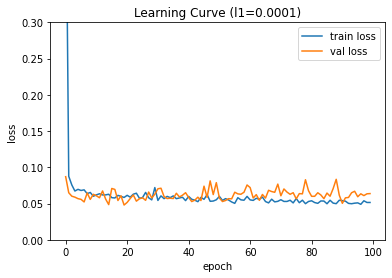

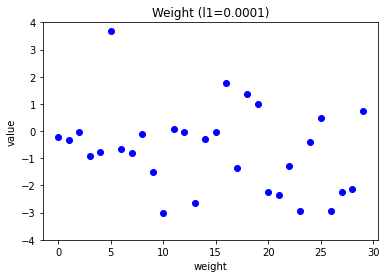

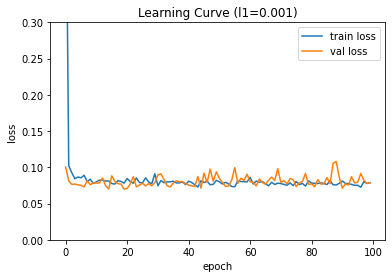

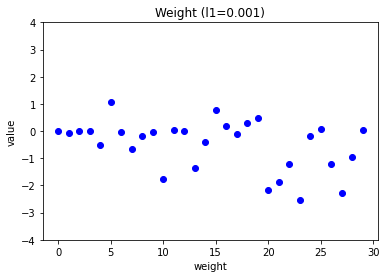

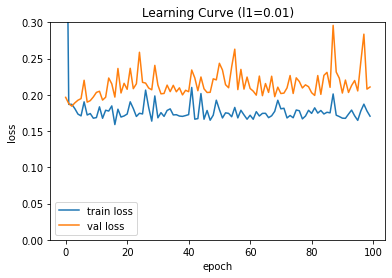

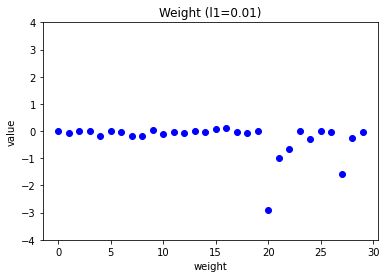

In [ ]:
# L1 규제 적용하기

l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1=l1)
  lyr.fit(train_data_scaled, train_target, x_val=val_data_scaled, y_val=val_target)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l1={})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1={})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

그래프를 보아하니 규제가 더 커질수록 훈련세트의 손실과 검증세트의 손실이 모두 높아진다 → 과소적합

l1 규제값이 커질수록 가중치의 값이 0에 가까워진다.   
적절한 l1 규제값은 0.001인 것으로 보인다.

In [ ]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(train_data_scaled, train_target, epochs=20)
layer5.score(val_data_scaled, val_target)

0.978021978021978

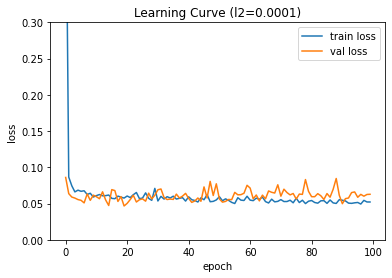

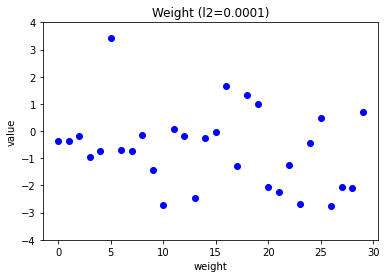

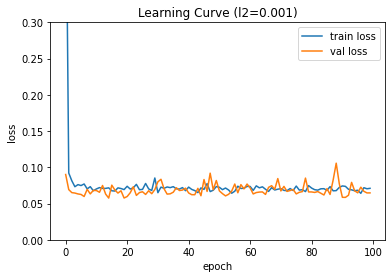

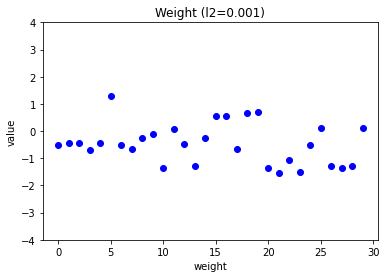

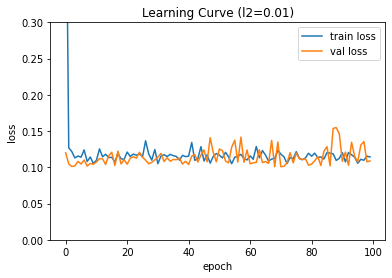

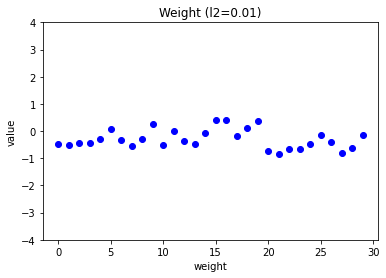

In [ ]:
# L2 규제 적용하기

l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(train_data_scaled, train_target, x_val=val_data_scaled, y_val=val_target)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l2={})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l2={})'.format(l2))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

L2 규제도 L1과 비슷한 양상을 보인다.   
하지만 L2 규제는 규제강도가 강해져도 L1 만큼 과소적합이 심해지지는 않는다.   
또한 가중치 역시 0에 너무 가깝게 줄어들지는 않는다는 것을 알 수 있다.
L2 규제 모델을 50에포크 훈련하고 성능을 테스트해보자.

In [ ]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(train_data_scaled, train_target, epochs=50)
layer6.score(val_data_scaled, val_target)

0.978021978021978

사실 cancer 데이터셋의 샘플 개수가 아주 적은 편이라 L1, L2 규제를 적용한 모델의 성능에는 큰 차이가 없다.

다시 말해서, 두 모델 모두 검증 샘플에 대해 옳게 예측한 샘플의 개수가 동일하다.(91개 샘플 중 89개)

In [ ]:
np.sum(layer6.predict(val_data_scaled) == val_target)

89

하지만 L2는 L1에 비해 에포크가 크게 늘어났다.   
가중치를 강하게 제한했기 때문에 검증세트의 손실값을 일정한 수준으로 유지하면서   
알고리즘이 전역최솟값을 찾는 과정을 오래 반복할 수 있다.

#**SGDClassifier에서 규제 사용하기**
SGDClassifier 클래스의 penalty 파라미터에 l1, l2를 입력하고 alpha 파라미터에 규제 강도를 지정한다.

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(train_data_scaled, train_target)
sgd.score(val_data_scaled, val_target)

0.978021978021978